In [1]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np

class FeatureRegressionDataset(Dataset):
    def __init__(self, X, y, feature):
        if isinstance(X, np.ndarray):
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X
        if isinstance(feature, np.ndarray):
            self.feature = torch.from_numpy(feature).float()
        else:
            self.feature = feature
        self.y = torch.from_numpy(y).float()
        # y shape이 (N,)이면 (N,1)로 바꿔주는 게 편할 때가 많음
        if self.y.ndim == 1:
            self.y = self.y.unsqueeze(1)
        if self.feature.ndim == 1:
            self.feature = self.feature.unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.feature[idx]


class FeatureDataset(Dataset):
    def __init__(self, X, feature):
        if isinstance(X, np.ndarray):
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X
        self.feature = torch.from_numpy(feature).float()
        # feature shape이 (N,)이면 (N,1)로 바꿔주는 게 편할 때가 많음
        if self.feature.ndim == 1:
            self.feature = self.feature.unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.feature[idx]


In [3]:
import numpy as np
import torch

# record_index
# vector_index
# diff_indices
# diff_values
# cost

json_diffs = np.load("../i_vectors_diffs.npz")
raw_input = json_diffs["diff_values"]

# input_data = json_diffs["diff_values"]
cost = -np.log(json_diffs["cost"])

In [5]:
import sys
sys.path.append("/root/work/tenset/scripts")

from tvm import auto_scheduler
from print_programs import return_program
from tvm.auto_scheduler.feature import get_per_store_features_from_file
from make_dataset import load_and_register_tasks
import numpy as np

json_file = "/root/work/tenset/dataset/measure_records_tenset/k80/([0bcb8746286db050cd088f375c85372d,1,64,64,128,6,6,32,128,1,64,64,32],cuda).json"

tasks = load_and_register_tasks()
inputs, results = auto_scheduler.RecordReader(json_file).read_lines()
raw_features, raw_normalized_throughputs, task_ids, min_latency = get_per_store_features_from_file(json_file, 10000)

In [6]:
features = []
for feature, throughput in zip(raw_features, raw_normalized_throughputs):
    if throughput > 1.0e-10:
        features.append(feature)


features = np.array(features, dtype=np.float32)
features_mean = np.mean(features, axis=1)
features_mean = torch.tensor(features_mean, dtype=torch.float32)
# (3464, 8, features_dim) -> (3464, features_dim)

features_mean = features_mean.view(features_mean.shape[0], -1)

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE_feature_head(nn.Module):
    def __init__(self, input_dim, latent_dim=16, hidden_dim=128):
        """
        input_dim: 2 * D (v_norm + is_zero concat한 차원)
        latent_dim: latent space 차원
        hidden_dim: MLP hidden 크기
        """
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        # self.decoder = nn.Sequential(
        #     nn.Linear(latent_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, input_dim),
            
        #     # 출력은 연속값이니까 activation 없이 그대로
        # )

        self.feature_predictor = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, features.shape[-1]),  # features.shape[1]는 feature 차원
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # def decode(self, z):
    #     return self.decoder(z)

    def predict_feature(self, z):
        return self.feature_predictor(z)

    def forward(self, x, use_mean=True):
        mu, logvar = self.encode(x)
        if use_mean:
            z = mu
        else:
            z = self.reparameterize(mu, logvar)
        # x_recon = self.decode(z)
        feature_pred = self.predict_feature(z)
        return mu, logvar, z, feature_pred

def vae_feature_loss(x, mu, logvar, feature_pred, feature, alpha=0.1, beta=1.0):
    """
    x, x_recon: (B, input_dim)
    mu, logvar: (B, latent_dim)

    beta: KL 가중치 (β-VAE 스타일로 조절)
    """
    # reconstruction loss: MSE
    feature_loss = F.mse_loss(feature_pred, feature, reduction="mean")

    # KL divergence: D_KL(q(z|x) || N(0, I))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    loss = beta * kl + alpha * feature_loss
    return loss, kl, feature_loss


In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

input_data = np.log(json_diffs["diff_values"]+1e-8)

scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)
feature_scaled = scaler.fit_transform(features_mean)

X_train, X_val, y_train, y_val, feature_train, feature_val = train_test_split(
    input_data_scaled, cost, feature_scaled,  test_size=0.2, random_state=42
)

# input_data, mean, std = transform_schedule(json_diffs["diff_values"])


In [49]:
from sklearn.metrics import r2_score
import torch
# 예시 세팅

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_dataset = FeatureDataset(X_train, feature_train)
val_dataset   = FeatureDataset(X_val,   feature_val)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=512, shuffle=False)



input_dim = X_train.shape[-1]
latent_dim = 64
hidden_dim = 256




vae = VAE_feature_head(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
torch.manual_seed(42)
np.random.seed(42)

# train_data: (N, D) int 텐서라고 가정
# train_data = torch.randint(low=0, high=1025, size=(1024, D))  # 예시용 dummy

# 전처리용 mean/std 미리 계산
# with torch.no_grad():
#     _x_cont, mean, std = transform_schedule(X_train.to(device))


alpha = 1.0
beta = 0.05
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# 간단한 에폭 루프 예시

epochs = 300
for epoch in range(epochs+1):
    # 여기서는 그냥 전체를 한 번에 돌린다고 가정 (실제로는 DataLoader로 배치 쪼개기)
    vae.train()
    for x_batch, feature_batch in train_loader:
        x_batch = x_batch.to(device)  # (N, D)
        feature_batch = feature_batch.to(device)
    
        # x_cont, _, _ = transform_schedule(x_batch, mean=mean, std=std)  # (N, 2D)

        mu, logvar, z, feature_pred = vae(x_batch, use_mean=False)

        loss, kl, feature_loss = vae_feature_loss(x_batch, mu, logvar, feature_pred, feature_batch, alpha=alpha, beta=beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    vae.eval()
    for x_batch, feature_batch in val_loader:
        x_batch = x_batch.to(device)
        feature_batch = feature_batch.to(device)
        mu, logvar, z, feature_pred = vae(x_batch, use_mean=True)
        val_loss, val_kl, val_feature_loss = vae_feature_loss(x_batch, mu, logvar, feature_pred, feature_batch, alpha=alpha, beta=beta)
        val_feature_r2 = r2_score(feature_batch.detach().cpu().numpy(), feature_pred.detach().cpu().numpy())

    if epoch % 20 == 0:
        print(f"epoch {epoch}: loss={loss.item():.4f}, kl={kl.item():.4f}")
        print(f"epoch {epoch}: val loss={val_loss.item():.4f}, val kl={val_kl.item():.4f}")
        
        print(val_feature_r2)


epoch 0: loss=0.4788, kl=0.0062
epoch 0: val loss=0.4748, val kl=0.0065
-0.0015027262012240344
epoch 20: loss=0.2000, kl=0.5013
epoch 20: val loss=0.1900, val kl=0.4901
0.30856620855265215
epoch 40: loss=0.1211, kl=0.6006
epoch 40: val loss=0.1261, val kl=0.5951
0.3791412711638368
epoch 60: loss=0.0925, kl=0.5738
epoch 60: val loss=0.1011, val kl=0.5805
0.40325207507549593
epoch 80: loss=0.0782, kl=0.5424
epoch 80: val loss=0.0862, val kl=0.5378
0.41587473411884773
epoch 100: loss=0.0701, kl=0.5265
epoch 100: val loss=0.0793, val kl=0.5253
0.422113634541222
epoch 120: loss=0.0589, kl=0.5036
epoch 120: val loss=0.0745, val kl=0.5025
0.42570659436185887
epoch 140: loss=0.0572, kl=0.4949
epoch 140: val loss=0.0707, val kl=0.4857
0.42869564404594196
epoch 160: loss=0.0531, kl=0.4769
epoch 160: val loss=0.0687, val kl=0.4748
0.43012655955751744
epoch 180: loss=0.0489, kl=0.4607
epoch 180: val loss=0.0654, val kl=0.4595
0.43277582085452493
epoch 200: loss=0.0463, kl=0.4520
epoch 200: val los

In [60]:
class VAECostPredictor(nn.Module):
    """
    VAE 기반 Cost Regression 모델
    
    구조:
    - input → segment_encoder → segment_sum → VAE encoder → z → cost_predictor → cost
    
    특징:
    - Pretrained VAE encoder를 finetune (작은 learning rate)
    - Cost predictor는 더 큰 learning rate로 학습
    - 전체 forward 경로가 완전히 미분 가능 (detach, stop_grad 없음)
    """
    
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, 
                 predictor_hidden=256, predictor_layers=2, dropout=0.1):
        super(VAECostPredictor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # ========== Cost Predictor (새로 학습) ==========
        predictor_modules = []
        current_dim = latent_dim
        for i in range(predictor_layers):
            predictor_modules.extend([
                nn.Linear(current_dim, predictor_hidden),
                nn.ReLU(),
                nn.Dropout(dropout) if i < predictor_layers - 1 else nn.Identity(),
            ])
            current_dim = predictor_hidden
        predictor_modules.append(nn.Linear(predictor_hidden, 1))
        
        self.cost_predictor = nn.Sequential(*predictor_modules)

        self.feature_predictor = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, features.shape[-1]),  # features.shape[1]는 feature 차원
        )
        
    
    def encode(self, input_data):
        """
        Full encoding path: features → z
        완전히 미분 가능
        """
                
        # VAE Encoder
        h = self.encoder(input_data)
        
        mean = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return mean, logvar, input_data
    
    def reparameterize(self, mean, logvar):
        """Reparameterization trick - 미분 가능"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def predict_cost(self, z):
        """z → cost prediction - 완전히 미분 가능"""
        return self.cost_predictor(z).squeeze(-1)
    
    def predict_feature(self, z):
        return self.feature_predictor(z)
    
    def forward(self, input_data, use_mean=True):
        """
        Forward pass: input → z → cost
        
        Args:
            use_mean: True면 reparameterize 대신 mean 사용 (inference용)
        
        Returns:
            cost_pred: 예측된 cost
            mean: latent mean
            logvar: latent log-variance
            z: sampled/mean latent vector
        """
        mean, logvar, input_data = self.encode(input_data)
        
        if use_mean:
            z = mean  # Inference시 deterministic
        else:
            z = self.reparameterize(mean, logvar)  # Training시 stochastic
        
        cost_pred = self.predict_cost(z)
        
        return cost_pred, mean, logvar, z
    
    def get_encoder_params(self):
        """Encoder 파라미터 (작은 lr)"""
        encoder_params = []
        encoder_params.extend(self.encoder.parameters())
        encoder_params.extend(self.fc_mu.parameters())
        encoder_params.extend(self.fc_logvar.parameters())
        return encoder_params
    
    def get_cost_predictor_params(self):
        """Predictor 파라미터 (큰 lr)"""
        predictor_params = []
        predictor_params.extend(self.cost_predictor.parameters())
        return predictor_params
    
    def get_feature_predictor_params(self):
        """Feature predictor 파라미터"""
        feature_params = []
        feature_params.extend(self.feature_predictor.parameters())
        return feature_params
    
    def load_pretrained_encoder(self, checkpoint):
        """Pretrained VAE encoder 가중치 로드"""
        

        vae_state = checkpoint
        
        # 매칭되는 키만 로드
        encoder_keys = ['encoder', 'fc_mu', 'fc_logvar', 'feature_predictor']
        own_state = self.state_dict()
        
        loaded_keys = []
        for name, param in vae_state.items():
            if any(name.startswith(k) for k in encoder_keys):
                if name in own_state and own_state[name].shape == param.shape:
                    own_state[name].copy_(param)
                    loaded_keys.append(name)
        
        print(f"Loaded {len(loaded_keys)} parameters from pretrained VAE")
        # return loaded_keys

def pair_accuracy(cost_pred, labels):
    """
    cost_pred, labels: (B,) 텐서
    """
    n_samples = min(1000, len(cost_pred))
    sample_indices = np.random.choice(len(cost_pred), n_samples, replace=False)

    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                idx_i = sample_indices[i]
                idx_j = sample_indices[j]
                pred_diff = cost_pred[idx_i] - cost_pred[idx_j]
                true_diff = labels[idx_i] - labels[idx_j]
                if (pred_diff * true_diff) > 0:
                    correct += 1
                total += 1
        accuracy = correct / total if total > 0 else 0.0
    return accuracy


In [61]:
def reg_loss_fn(cost_pred, cost_true, loss_type='mse'):
    """
    기본 회귀 손실 (MSE 또는 MAE)
    """
    if loss_type == 'mse':
        return F.mse_loss(cost_pred, cost_true)
    else:  # mae
        return F.l1_loss(cost_pred, cost_true)


def pair_loss_fn(cost_pred, cost_true, margin=0.1):
    """
    Pairwise ranking loss: 실제 cost 순서를 예측이 유지하도록.
    cost_true[i] < cost_true[j] 이면 cost_pred[i] < cost_pred[j] + margin
    """
    batch_size = cost_pred.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=cost_pred.device)
    
    # 모든 쌍에 대해 ranking loss 계산
    idx = torch.arange(batch_size, device=cost_pred.device)
    i_idx, j_idx = torch.meshgrid(idx, idx, indexing='ij')
    mask = i_idx < j_idx  # upper triangular only
    
    pred_i = cost_pred[i_idx[mask]]
    pred_j = cost_pred[j_idx[mask]]
    true_i = cost_true[i_idx[mask]]
    true_j = cost_true[j_idx[mask]]
    
    # label: 1 if true_i < true_j, -1 otherwise
    labels = torch.sign(true_j - true_i).float()
    
    # Margin ranking loss
    loss = F.margin_ranking_loss(pred_j.view(-1), pred_i.view(-1), labels.view(-1), margin=margin)
    return loss


def smooth_loss_fn(model, z, noise_std=0.1):
    """
    Smoothness loss: z에 작은 노이즈를 더했을 때 예측이 크게 변하지 않도록.
    """
    z_noisy = z + noise_std * torch.randn_like(z)
    
    cost_original = model.predict_cost(z)
    cost_noisy = model.predict_cost(z_noisy)
    
    smooth_loss = F.mse_loss(cost_original, cost_noisy)
    return smooth_loss


def kld_loss_fn(mean, logvar):
    """
    KL Divergence: q(z|x) || N(0, I)
    """
    kld = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    return kld

def feature_loss_fn(feature_pred, feature_true, coef=0.1):
    """
    Feature 예측 손실 (MSE)
    """
    return F.mse_loss(feature_pred, feature_true) * coef


def compute_total_loss(model, cost_pred, mean, logvar, z, labels, feature, config, return_components=True):
    """
    Total loss 계산 (Segment 기반 데이터용).
    total_loss = reg_loss + λ_pair * pair_loss + γ * smooth_loss + β * kld_loss
    """
    
    # Individual losses
    reg = reg_loss_fn(cost_pred, labels, loss_type=config.get('loss_type', 'mse'))
    pair = pair_loss_fn(cost_pred.view(-1), labels.view(-1), margin=config.get('margin', 0.1))
    smooth = smooth_loss_fn(model, z, noise_std=config.get('noise_std', 0.1))
    kld = kld_loss_fn(mean, logvar)
    feature_loss = feature_loss_fn(model.predict_feature(z), feature, coef=config.get('alpha', 0.1))
    
    # Weighted sum
    total = config['lambda_reg'] * reg + config['lambda_pair'] * pair + config['gamma'] * smooth + config['beta'] * kld + feature_loss
    
    if return_components:
        return total, {
            'reg_loss': reg.item(),
            'pair_loss': pair.item(),
            'smooth_loss': smooth.item(),
            'kld_loss': kld.item(),
            'feature_loss': feature_loss.item(),
        }
    return total

In [64]:
input_data = np.log(json_diffs["diff_values"]+1e-8)
costs = -np.log(json_diffs["cost"])


scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)
features_scaled = scaler.fit_transform(features_mean)

# X_train, X_val, y_train, y_val = train_test_split(
#     input_data_scaled, costs, test_size=0.2, random_state=42
# )

X_train, X_val, y_train, y_val, feature_train, feature_val = train_test_split(
    input_data_scaled, costs, features_scaled,  test_size=0.2, random_state=42
)

train_dataset = FeatureRegressionDataset(X_train, y_train, feature_train)
val_dataset   = FeatureRegressionDataset(X_val,   y_val, feature_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False)





In [65]:
input_data = np.log(json_diffs["diff_values"]+1e-8)
costs = -np.log(json_diffs["cost"])


train_size = 64

np.random.seed(42)
random_indices = np.random.permutation(len(input_data))

scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)
features_scaled = scaler.fit_transform(features_mean)
costs_scaled = (costs - costs.mean()) / (costs.std() + 1e-8)

X_train = input_data_scaled[random_indices[:train_size]]
X_val = input_data_scaled[random_indices[train_size:]]
y_train = costs[random_indices[:train_size]]
y_val = costs[random_indices[train_size:]]

train_dataset = FeatureRegressionDataset(X_train, y_train, features_scaled[random_indices[:train_size]])
val_dataset   = FeatureRegressionDataset(X_val,   y_val, features_scaled[random_indices[train_size:]])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=512, shuffle=False)

y_mean = y_train.mean()
y_std = y_train.std() + 1e-8  # 0 나누기 방지용 작은 값 추가
print(f"y_train mean: {y_mean}, std: {y_std}")

y_train mean: 6.333581531911031, std: 1.3555901482101775


In [69]:
import itertools
input_dim = X_train.shape[-1]
latent_dim = 64
hidden_dim = 256



margin_scale = 0.3




# for seed in range(2023, 2024):



# print("Margin scale:", margin_scale)

hyperparameter = {
    # 'alpha': [1e-4, 1e-3],
    'alpha': [1e-4],
    'seed': range(2000, 2010),
}
# 깔끔하게 for문 하나로

history = {seed: {"val_reg_r2" : [], "val_rank_r2" : []} for seed in hyperparameter['seed']}

for vals in itertools.product(*hyperparameter.values()):
    vae_cost_model = VAECostPredictor(input_dim=input_dim, 
                                    latent_dim=latent_dim, 
                                    hidden_dim=hidden_dim, 
                                    predictor_layers=2,
                                    dropout=0.1).to(device)
    vae_cost_model.load_pretrained_encoder(vae.state_dict())
    alpha = vals[0]
    seed = vals[1]
    torch.manual_seed(seed)
    print("alpha:", alpha)
    print("seed:", seed)

    config = {
                'encoder_lr': 5e-4,
                'feature_predictor_lr': 1e-2,
                'cost_predictor_lr': 1e-2,
                'lambda_reg' : 0.01,
                'lambda_pair': 2.0,
                'gamma': 0.1,
                'beta': 0.05,
                'margin': margin_scale * y_std,
                'noise_std': 0.001,
                'alpha': alpha,
                'loss_type': 'mse',
                # 'samples_per_phase': 64,
                'mini_epochs': epoch,
            }



    optimizer = torch.optim.AdamW([
            {'params': vae_cost_model.get_encoder_params(), 'lr': config['encoder_lr']},
            {'params': vae_cost_model.get_feature_predictor_params(), 'lr': config['feature_predictor_lr']},
            {'params': vae_cost_model.get_cost_predictor_params(), 'lr': config['cost_predictor_lr']}

        ], weight_decay=1e-5)


    epochs = 1000

    for epoch in range(1, epochs+1):
        vae_cost_model.train()
        for x_batch, labels, features in train_loader:
            x_batch = x_batch.to(device)
            labels = labels.to(device).squeeze(-1)
            features = features.to(device)
            
        
            cost_pred, mean, logvar, z = vae_cost_model(x_batch, use_mean=False)

            train_loss, train_components = compute_total_loss(vae_cost_model, 
                                                    cost_pred, mean, logvar, z, labels, features, config)

            optimizer.zero_grad()
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(vae_cost_model.parameters(), max_norm=1.0)
            optimizer.step()
            
        

        if epoch % epochs == 0:
            vae_cost_model.eval()
            all_preds = []
            all_labels = []
            for x_batch, labels, features in val_loader:
                x_batch = x_batch.to(device)
                labels = labels.to(device).squeeze(-1)
                features = features.to(device)

                cost_pred, mean, logvar, z = vae_cost_model(x_batch, use_mean=True)

                val_loss, val_components = compute_total_loss(vae_cost_model, cost_pred, mean, logvar, z, labels, features, config)
            val_reg_r2 = r2_score(cost_pred.detach().cpu().numpy(), labels.detach().cpu().numpy())
                
            print(f"Train loss epoch {epoch} : reg={train_components['reg_loss']: .4f} rank={train_components['pair_loss']: .4f} kl={train_components['kld_loss']: .4f}")
            print(f"Val loss epoch {epoch}: reg={val_components['reg_loss']: .4f} rank={val_components['pair_loss']: .4f} kl={val_components['kld_loss']: .4f}")
            
            print(val_reg_r2)
        
        # rank r2 계산
        if epoch == epochs:
            all_preds = []
            all_labels = []
            for x_batch, labels, features in val_loader:
                x_batch = x_batch.to(device)
                labels = labels.to(device).squeeze(-1)
                features = features.to(device)
                cost_pred, mean, logvar, z = vae_cost_model(x_batch, use_mean=True)
                all_preds.append(cost_pred.detach().cpu().numpy())
                all_labels.append(labels.detach().cpu().numpy())
            all_preds = np.concatenate(all_preds, axis=0)
            all_labels = np.concatenate(all_labels, axis=0)
            val_rank_r2 = pair_accuracy(all_preds, all_labels)
            # print(f"Train loss epoch {epoch} : reg={train_components['reg_loss']: .4f} rank={train_components['pair_loss']: .4f} kl={train_components['kld_loss']: .4f}")
            # print(f"Val loss epoch {epoch}: reg={val_components['reg_loss']: .4f} rank={val_components['pair_loss']: .4f} kl={val_components['kld_loss']: .4f}")
            # print(val_reg_r2)
            history[seed]["val_reg_r2"].append(val_reg_r2)
            history[seed]["val_rank_r2"].append(val_rank_r2)
            print(f"Validation Pairwise Accuracy at epoch {epoch}: {val_rank_r2:.4f}")
            print("=============================================")



for metric in ["val_reg_r2", "val_rank_r2"]:
    print(f"Metric: {metric}")
    all_values = []
    for seed in hyperparameter['seed']:
        values = history[seed][metric]
        all_values.extend(values)
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"  Seed {seed}: Mean={mean_val:.4f}, Std={std_val:.4f}")
    
    overall_mean = np.mean(all_values)
    overall_std = np.std(all_values)
    print(f"Overall: Mean={overall_mean:.4f}, Std={overall_std:.4f}")

Loaded 16 parameters from pretrained VAE
alpha: 0.0001
seed: 2000
Train loss epoch 1000 : reg= 0.6618 rank= 0.0205 kl= 0.1788
Val loss epoch 1000: reg= 1.4473 rank= 0.3270 kl= 0.1665
0.5670186528081853
Validation Pairwise Accuracy at epoch 1000: 0.8015
Loaded 16 parameters from pretrained VAE
alpha: 0.0001
seed: 2001
Train loss epoch 1000 : reg= 0.6575 rank= 0.0201 kl= 0.1888
Val loss epoch 1000: reg= 1.3344 rank= 0.3103 kl= 0.1729
0.5236390242233309
Validation Pairwise Accuracy at epoch 1000: 0.7953
Loaded 16 parameters from pretrained VAE
alpha: 0.0001
seed: 2002
Train loss epoch 1000 : reg= 0.7234 rank= 0.0207 kl= 0.1906
Val loss epoch 1000: reg= 1.4631 rank= 0.3154 kl= 0.1767
0.533195680825994
Validation Pairwise Accuracy at epoch 1000: 0.8066
Loaded 16 parameters from pretrained VAE
alpha: 0.0001
seed: 2003
Train loss epoch 1000 : reg= 0.9444 rank= 0.0173 kl= 0.1493
Val loss epoch 1000: reg= 1.5555 rank= 0.3130 kl= 0.1365
0.39031433335448396
Validation Pairwise Accuracy at epoch 1

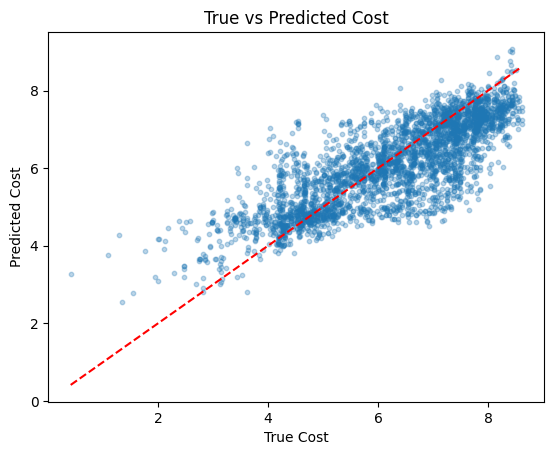

In [290]:
# true, pred cost 시각화

import matplotlib.pyplot as plt

plt.scatter(all_labels, all_preds, alpha=0.3, s=10)
plt.xlabel("True Cost")
plt.ylabel("Predicted Cost")
plt.title("True vs Predicted Cost")
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--')  # y=x 선

plt.show()


In [233]:
enc_params = sum(p.numel() for p in vae_cost_model.get_encoder_params())
cost_params = sum(p.numel() for p in vae_cost_model.get_predictor_params())
print(f"\n모델 파라미터 수:")
print(f"   Encoder: {enc_params:,}")
print(f"   Cost Predictor: {cost_params:,}")
print(f"   Total: {enc_params + cost_params:,}")


모델 파라미터 수:
   Encoder: 172,928
   Cost Predictor: 207,269
   Total: 380,197
